<h1><b><i>Ο αλγόριθμος Προσομοιωμένης Ανόπτησης</i> (<i>Simulated Annealing</i>)</b></h1>

Στην άσκηση αυτή θα μελετήσετε τον αλγόριθμο της <i>Προσομοιωμένης Ανόπτησης</i> (<i>Simulated Annealing</i>), περισσότερες πληροφορίες για τον οποίο μπορείτε να βρείτε <a href="https://en.wikipedia.org/wiki/Simulated_annealing">εδώ</a>.Θα χρησιμοποιήσετε τα <b>δύο έτοιμα</b> προγράμματα που δίνονται στη συνέχεια. Τα προγράμματα αυτά επιλύουν το πρόβλημα του <i>Περιπλανώμενου Πωλητή</i> (<i>Travelling Salesman Problem</i>, <i>TSP</i>), περισσότερες πληροφορίες για το οποίο μπορείτε να βρείτε <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">εδώ</a>. Το πρώτο πρόγραμμα επιλύει το πρόβλημα <i>TSP</i> χρησιμοποιώντας τον αλγόριθμο <i>Simulated Annealing</i> και το δεύτερο επιλύει το ίδιο πρόβλημα, χρησιμοποιώντας τον αλγόριθμο <a href="https://en.wikipedia.org/wiki/Hill_climbing"><i>Hill Climbing</i></a>. Η επίλυση του προβλήματος γίνεται για <b>150 πόλεις</b>.

<b>Σημείωση:</b> Βεβαιωθείτε ότι το <b><i>Runtime Environment</i></b> είναι για <b><i>Python 2</i></b>.

<h2><b><i>Simulated Annealing</i></b></h2>

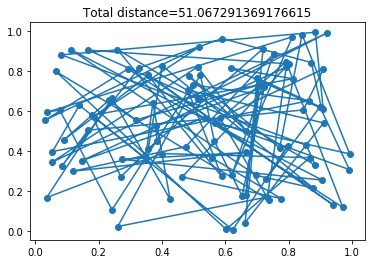

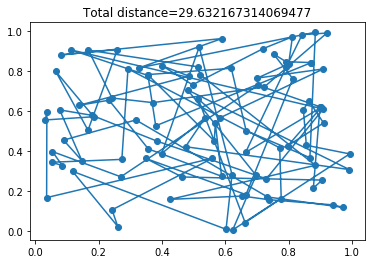

T=   0.20000 , distance=   29.63217 , accepted steps= 1001


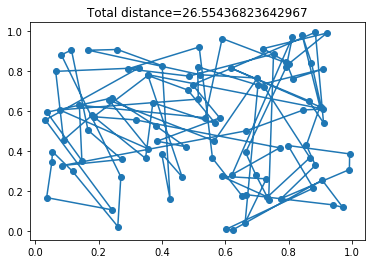

T=   0.18000 , distance=   26.55437 , accepted steps= 1001


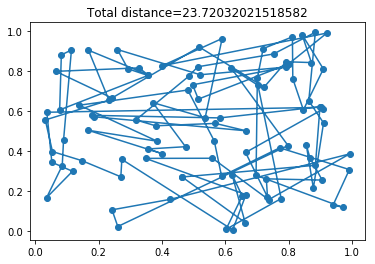

T=   0.16200 , distance=   23.72032 , accepted steps= 1001


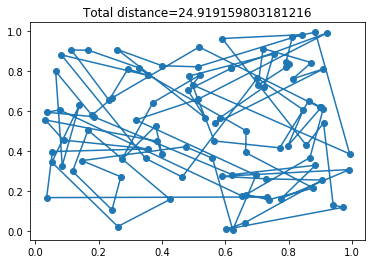

T=   0.14580 , distance=   24.91916 , accepted steps= 1001


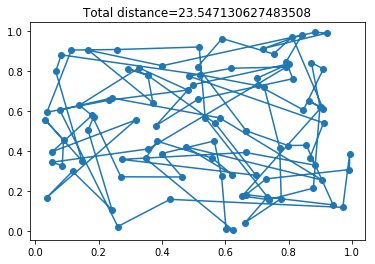

T=   0.13122 , distance=   23.54713 , accepted steps= 1001


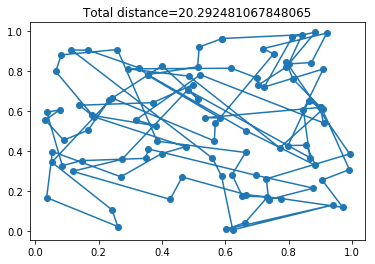

T=   0.11810 , distance=   20.29248 , accepted steps= 1001


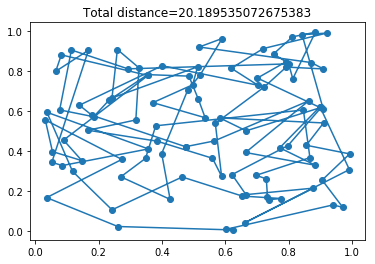

T=   0.10629 , distance=   20.18954 , accepted steps= 1001


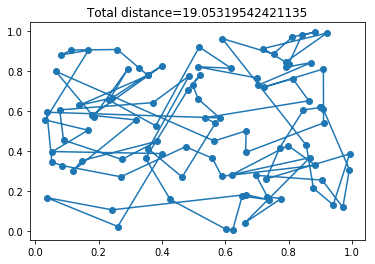

T=   0.09566 , distance=   19.05320 , accepted steps= 749


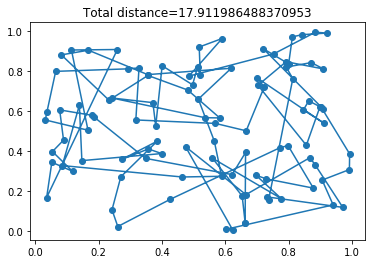

T=   0.08609 , distance=   17.91199 , accepted steps= 598


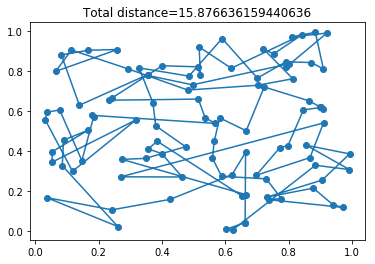

T=   0.07748 , distance=   15.87664 , accepted steps= 558


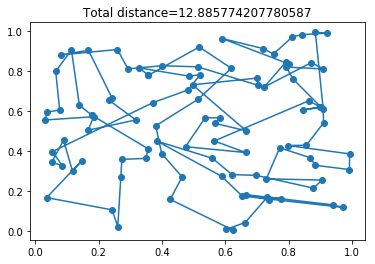

T=   0.06974 , distance=   12.88577 , accepted steps= 430


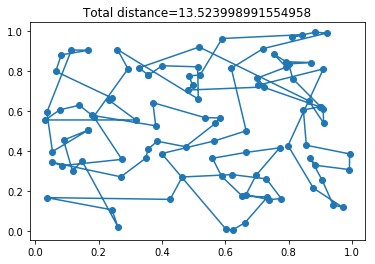

T=   0.06276 , distance=   13.52400 , accepted steps= 321


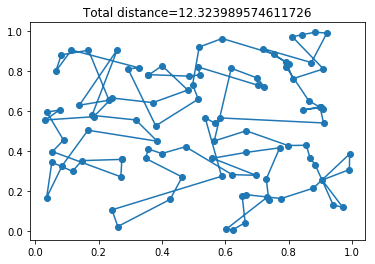

T=   0.05649 , distance=   12.32399 , accepted steps= 283


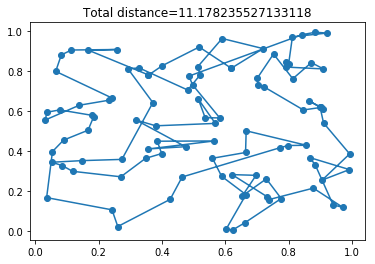

T=   0.05084 , distance=   11.17824 , accepted steps= 234


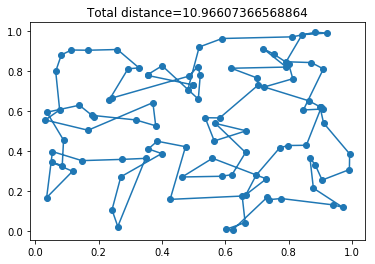

T=   0.04575 , distance=   10.96607 , accepted steps= 180


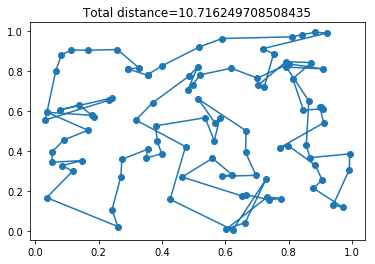

T=   0.04118 , distance=   10.71625 , accepted steps= 154


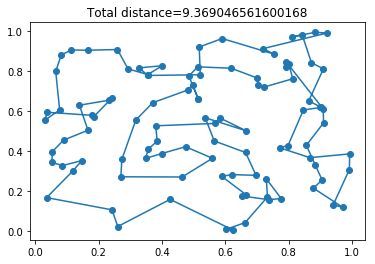

T=   0.03706 , distance=    9.36905 , accepted steps= 123


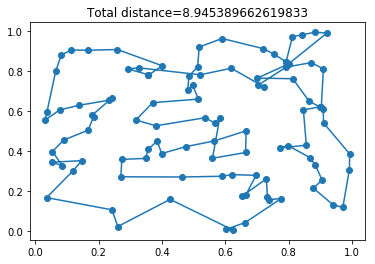

T=   0.03335 , distance=    8.94539 , accepted steps= 69


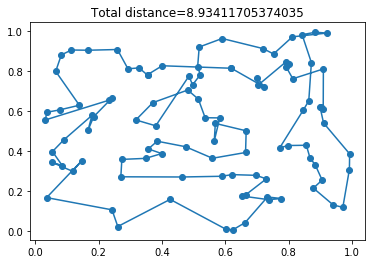

T=   0.03002 , distance=    8.93412 , accepted steps= 76


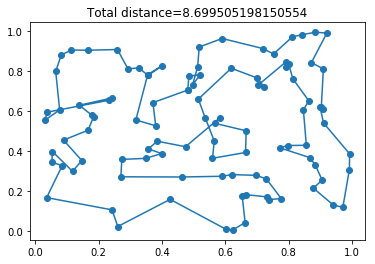

T=   0.02702 , distance=    8.69951 , accepted steps= 56


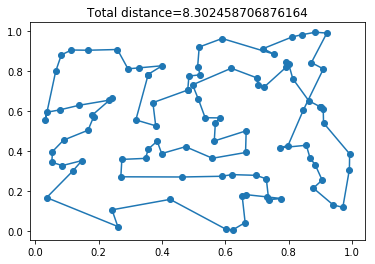

T=   0.02432 , distance=    8.30246 , accepted steps= 42


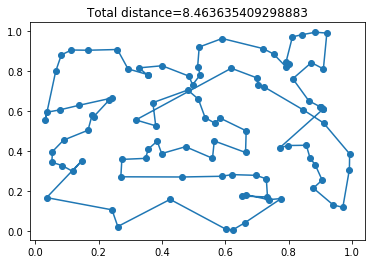

T=   0.02188 , distance=    8.46364 , accepted steps= 45


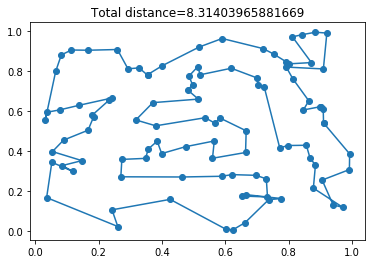

T=   0.01970 , distance=    8.31404 , accepted steps= 49


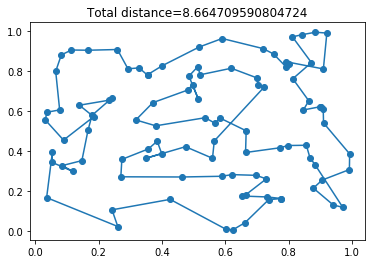

T=   0.01773 , distance=    8.66471 , accepted steps= 50


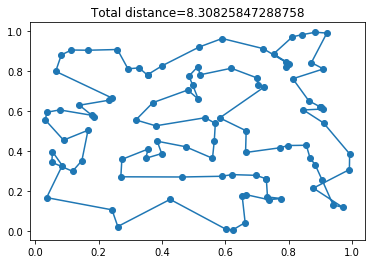

T=   0.01595 , distance=    8.30826 , accepted steps= 36


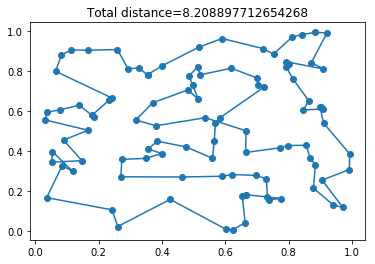

T=   0.01436 , distance=    8.20890 , accepted steps= 23


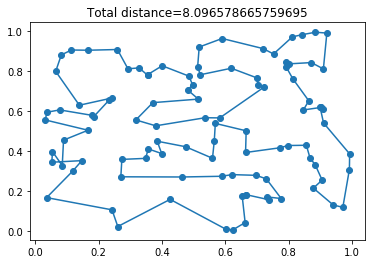

T=   0.01292 , distance=    8.09658 , accepted steps= 28


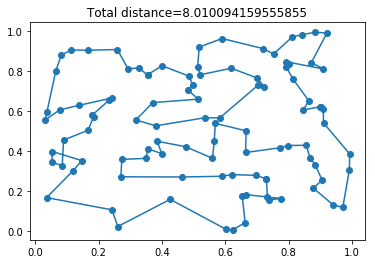

T=   0.01163 , distance=    8.01009 , accepted steps= 17


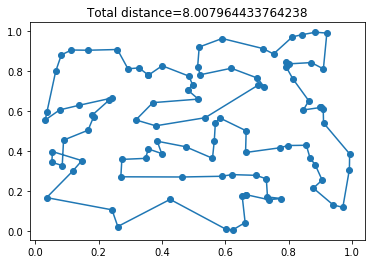

T=   0.01047 , distance=    8.00796 , accepted steps= 13


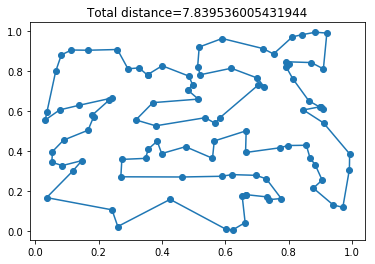

T=   0.00942 , distance=    7.83954 , accepted steps= 13


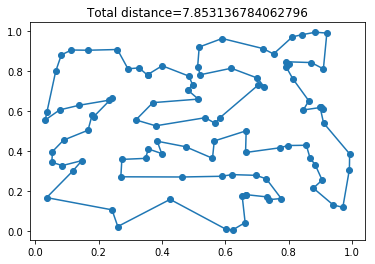

T=   0.00848 , distance=    7.85314 , accepted steps= 6


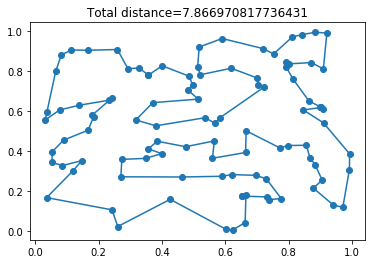

T=   0.00763 , distance=    7.86697 , accepted steps= 15


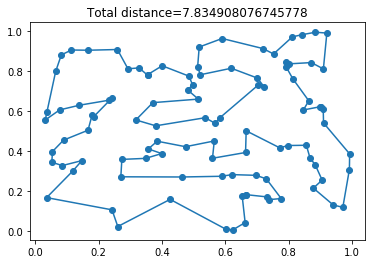

T=   0.00687 , distance=    7.83491 , accepted steps= 7


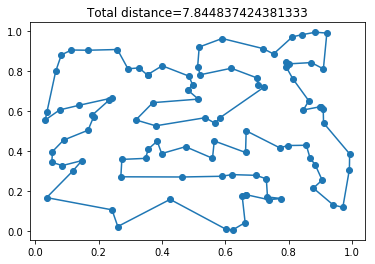

T=   0.00618 , distance=    7.84484 , accepted steps= 12


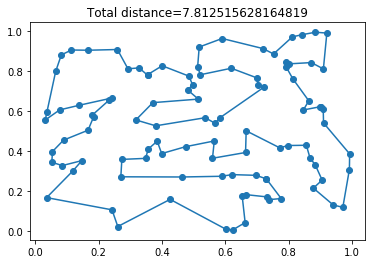

T=   0.00556 , distance=    7.81252 , accepted steps= 3


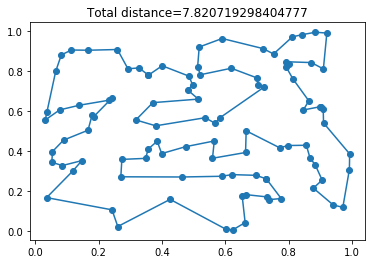

T=   0.00501 , distance=    7.82072 , accepted steps= 6


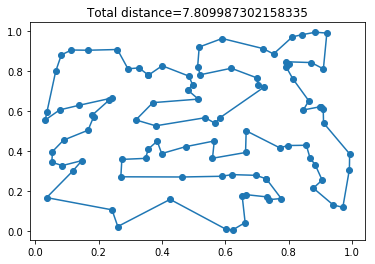

T=   0.00451 , distance=    7.80999 , accepted steps= 8


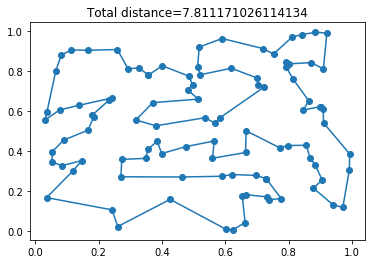

T=   0.00406 , distance=    7.81117 , accepted steps= 5


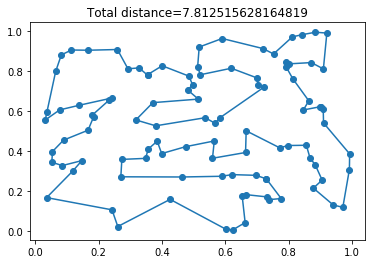

T=   0.00365 , distance=    7.81252 , accepted steps= 5


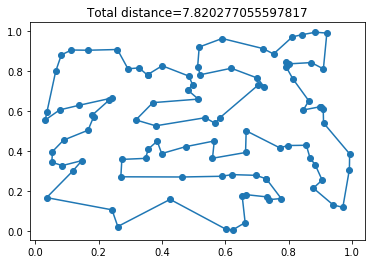

T=   0.00328 , distance=    7.82028 , accepted steps= 3


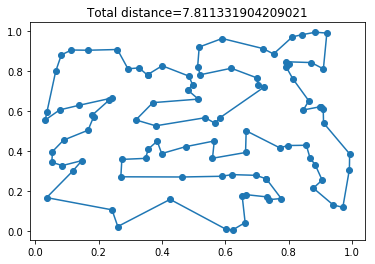

T=   0.00296 , distance=    7.81133 , accepted steps= 2


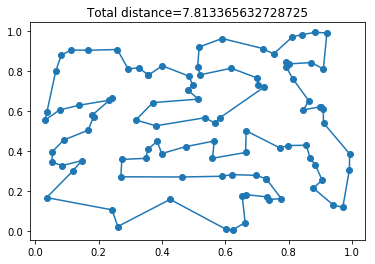

T=   0.00266 , distance=    7.81337 , accepted steps= 3


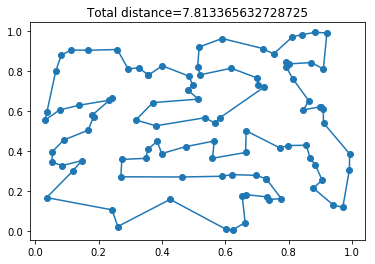

T=   0.00239 , distance=    7.81337 , accepted steps= 2


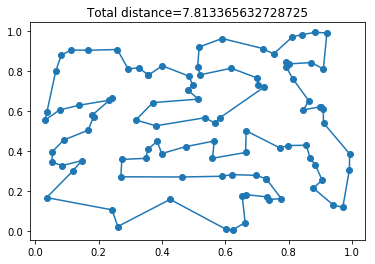

T=   0.00216 , distance=    7.81337 , accepted steps= 2


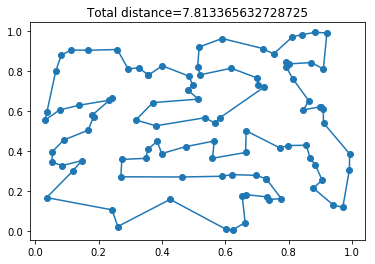

T=   0.00194 , distance=    7.81337 , accepted steps= 2


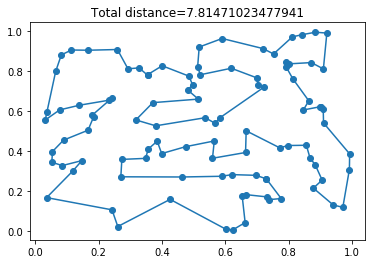

T=   0.00175 , distance=    7.81471 , accepted steps= 3


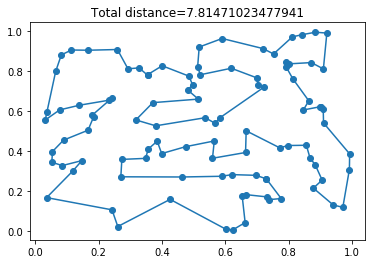

T=   0.00157 , distance=    7.81471 , accepted steps= 0


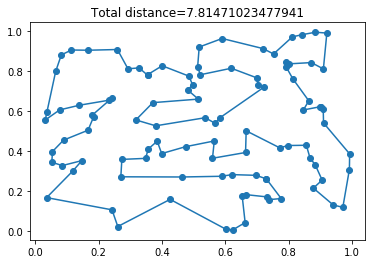

In [13]:
#!/usr/bin/env python

""" Traveling salesman problem solved using Simulated Annealing.
http://www.physics.rutgers.edu/~haule/681/src_MC/python_codes/salesman.py
"""
from scipy import *
from pylab import *

def Distance(R1, R2):
    return sqrt((R1[0]-R2[0])**2+(R1[1]-R2[1])**2)

def TotalDistance(city, R):
    dist=0
    for i in range(len(city)-1):
        dist += Distance(R[city[i]],R[city[i+1]])
    dist += Distance(R[city[-1]],R[city[0]])
    return dist
    
def reverse(city, n):
    nct = len(city)
    nn = (1+ ((n[1]-n[0]) % nct))/2 # half the lenght of the segment to be reversed
    # the segment is reversed in the following way n[0]<->n[1], n[0]+1<->n[1]-1, n[0]+2<->n[1]-2,...
    # Start at the ends of the segment and swap pairs of cities, moving towards the center.
    for j in range(nn):
        k = (n[0]+j) % nct
        l = (n[1]-j) % nct
        (city[k],city[l]) = (city[l],city[k])  # swap
    
def transpt(city, n):
    nct = len(city)
    
    newcity=[]
    # Segment in the range n[0]...n[1]
    for j in range( (n[1]-n[0])%nct + 1):
        newcity.append(city[ (j+n[0])%nct ])
    # is followed by segment n[5]...n[2]
    for j in range( (n[2]-n[5])%nct + 1):
        newcity.append(city[ (j+n[5])%nct ])
    # is followed by segment n[3]...n[4]
    for j in range( (n[4]-n[3])%nct + 1):
        newcity.append(city[ (j+n[3])%nct ])
    return newcity

def Plot(city, R, dist):
    # Plot
    Pt = [R[city[i]] for i in range(len(city))]
    Pt += [R[city[0]]]
    Pt = array(Pt)
    title('Total distance='+str(dist))
    plot(Pt[:,0], Pt[:,1], '-o')
    show()

if __name__=='__main__':

    ncity = 150        # Number of cities to visit
    maxTsteps = 100    # Temperature is lowered not more than maxTsteps
    Tstart = 0.2       # Starting temperature - has to be high enough
    fCool = 0.9        # Factor to multiply temperature at each cooling step
    maxSteps = 100*ncity     # Number of steps at constant temperature
    maxAccepted = 10*ncity   # Number of accepted steps at constant temperature

    Preverse = 0.5      # How often to choose reverse/transpose trial move

    # Choosing city coordinates
    R=[]  # coordinates of cities are choosen randomly
    for i in range(ncity):
        R.append( [rand(),rand()] )
    R = array(R)

    # The index table -- the order the cities are visited.
    city = range(ncity)
    # Distance of the travel at the beginning
    dist = TotalDistance(city, R)

    # Stores points of a move
    n = zeros(6, dtype=int)
    nct = len(R) # number of cities
    
    T = Tstart # temperature

    Plot(city, R, dist)
    
    for t in range(maxTsteps):  # Over temperature

        accepted = 0
        for i in range(maxSteps): # At each temperature, many Monte Carlo steps
            
            while True: # Will find two random cities sufficiently close by
                # Two cities n[0] and n[1] are choosen at random
                n[0] = int((nct)*rand())     # select one city
                n[1] = int((nct-1)*rand())   # select another city, but not the same
                if (n[1] >= n[0]): n[1] += 1   #
                if (n[1] < n[0]): (n[0],n[1]) = (n[1],n[0]) # swap, because it must be: n[0]<n[1]
                nn = (n[0]+nct -n[1]-1) % nct  # number of cities not on the segment n[0]..n[1]
                if nn>=3: break
        
            # We want to have one index before and one after the two cities
            # The order hence is [n2,n0,n1,n3]
            n[2] = (n[0]-1) % nct  # index before n0  -- see figure in the lecture notes
            n[3] = (n[1]+1) % nct  # index after n2   -- see figure in the lecture notes
            
            if Preverse > rand(): 
                # Here we reverse a segment
                # What would be the cost to reverse the path between city[n[0]]-city[n[1]]?
                de = Distance(R[city[n[2]]],R[city[n[1]]]) + Distance(R[city[n[3]]],R[city[n[0]]]) - Distance(R[city[n[2]]],R[city[n[0]]]) - Distance(R[city[n[3]]],R[city[n[1]]])
                
                if de<0 or exp(-de/T)>rand(): # Metropolis
                    accepted += 1
                    dist += de
                    reverse(city, n)
            else:
                # Here we transpose a segment
                nc = (n[1]+1+ int(rand()*(nn-1)))%nct  # Another point outside n[0],n[1] segment. See picture in lecture nodes!
                n[4] = nc
                n[5] = (nc+1) % nct
        
                # Cost to transpose a segment
                de = -Distance(R[city[n[1]]],R[city[n[3]]]) - Distance(R[city[n[0]]],R[city[n[2]]]) - Distance(R[city[n[4]]],R[city[n[5]]])
                de += Distance(R[city[n[0]]],R[city[n[4]]]) + Distance(R[city[n[1]]],R[city[n[5]]]) + Distance(R[city[n[2]]],R[city[n[3]]])
                
                if de<0 or exp(-de/T)>rand(): # Metropolis
                    accepted += 1
                    dist += de
                    city = transpt(city, n)
                    
            if accepted > maxAccepted: break

        # Plot
        Plot(city, R, dist)
            
        print "T=%10.5f , distance= %10.5f , accepted steps= %d" %(T, dist, accepted)
        T *= fCool             # The system is cooled down
        if accepted == 0: break  # If the path does not want to change any more, we can stop

        
    Plot(city, R, dist)


<h2><b><i>Hill Climbing</i></b></h2>

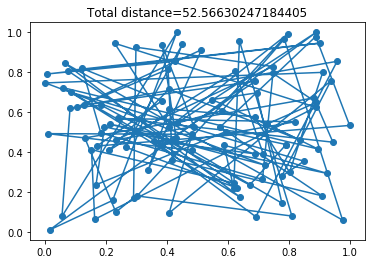

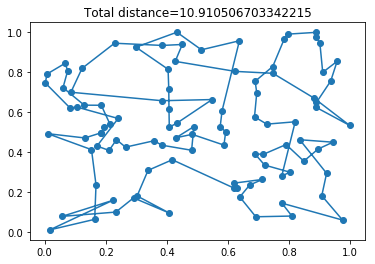

T=   0.20000 , distance=   10.91051 , accepted steps= 244


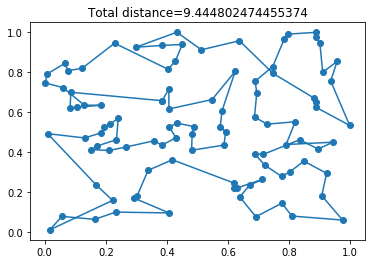

T=   0.18000 , distance=    9.44480 , accepted steps= 33


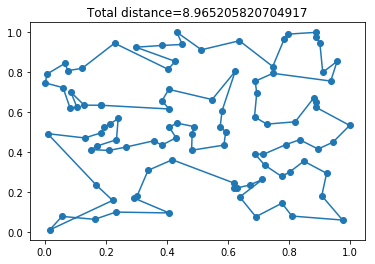

T=   0.16200 , distance=    8.96521 , accepted steps= 15


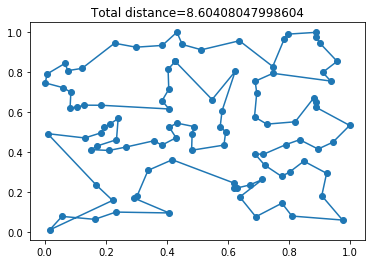

T=   0.14580 , distance=    8.60408 , accepted steps= 6


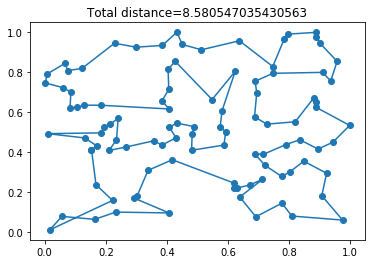

T=   0.13122 , distance=    8.58055 , accepted steps= 4


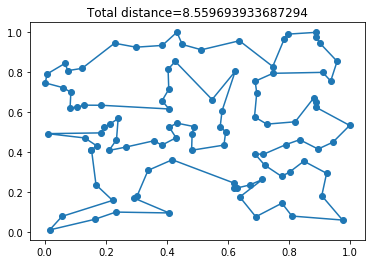

T=   0.11810 , distance=    8.55969 , accepted steps= 1


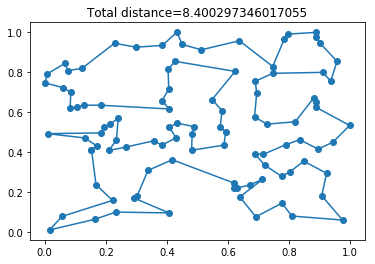

T=   0.10629 , distance=    8.40030 , accepted steps= 1


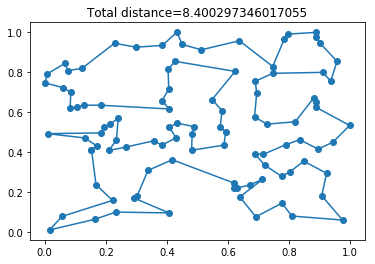

T=   0.09566 , distance=    8.40030 , accepted steps= 0


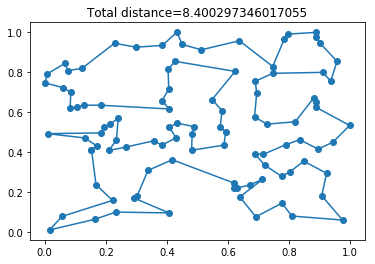

In [14]:
#!/usr/bin/env python

""" Traveling salesman problem solved using Simulated Annealing.
http://www.physics.rutgers.edu/~haule/681/src_MC/python_codes/salesman.py
"""
from scipy import *
from pylab import *

def Distance(R1, R2):
    return sqrt((R1[0]-R2[0])**2+(R1[1]-R2[1])**2)

def TotalDistance(city, R):
    dist=0
    for i in range(len(city)-1):
        dist += Distance(R[city[i]],R[city[i+1]])
    dist += Distance(R[city[-1]],R[city[0]])
    return dist
    
def reverse(city, n):
    nct = len(city)
    nn = (1+ ((n[1]-n[0]) % nct))/2 # half the lenght of the segment to be reversed
    # the segment is reversed in the following way n[0]<->n[1], n[0]+1<->n[1]-1, n[0]+2<->n[1]-2,...
    # Start at the ends of the segment and swap pairs of cities, moving towards the center.
    for j in range(nn):
        k = (n[0]+j) % nct
        l = (n[1]-j) % nct
        (city[k],city[l]) = (city[l],city[k])  # swap
    
def transpt(city, n):
    nct = len(city)
    
    newcity=[]
    # Segment in the range n[0]...n[1]
    for j in range( (n[1]-n[0])%nct + 1):
        newcity.append(city[ (j+n[0])%nct ])
    # is followed by segment n[5]...n[2]
    for j in range( (n[2]-n[5])%nct + 1):
        newcity.append(city[ (j+n[5])%nct ])
    # is followed by segment n[3]...n[4]
    for j in range( (n[4]-n[3])%nct + 1):
        newcity.append(city[ (j+n[3])%nct ])
    return newcity

def Plot(city, R, dist):
    # Plot
    Pt = [R[city[i]] for i in range(len(city))]
    Pt += [R[city[0]]]
    Pt = array(Pt)
    title('Total distance='+str(dist))
    plot(Pt[:,0], Pt[:,1], '-o')
    show()

if __name__=='__main__':

    ncity = 150       # Number of cities to visit
    maxTsteps = 100    # Temperature is lowered not more than maxTsteps
    Tstart = 0.2       # Starting temperature - has to be high enough
    fCool = 0.9        # Factor to multiply temperature at each cooling step
    maxSteps = 100*ncity     # Number of steps at constant temperature
    maxAccepted = 10*ncity   # Number of accepted steps at constant temperature

    Preverse = 0.5      # How often to choose reverse/transpose trial move

    # Choosing city coordinates
    R=[]  # coordinates of cities are choosen randomly
    for i in range(ncity):
        R.append( [rand(),rand()] )
    R = array(R)

    # The index table -- the order the cities are visited.
    city = range(ncity)
    # Distance of the travel at the beginning
    dist = TotalDistance(city, R)

    # Stores points of a move
    n = zeros(6, dtype=int)
    nct = len(R) # number of cities
    
    T = Tstart # temperature

    Plot(city, R, dist)
    
    for t in range(maxTsteps):  # Over temperature

        accepted = 0
        for i in range(maxSteps): # At each temperature, many Monte Carlo steps
            
            while True: # Will find two random cities sufficiently close by
                # Two cities n[0] and n[1] are choosen at random
                n[0] = int((nct)*rand())     # select one city
                n[1] = int((nct-1)*rand())   # select another city, but not the same
                if (n[1] >= n[0]): n[1] += 1   #
                if (n[1] < n[0]): (n[0],n[1]) = (n[1],n[0]) # swap, because it must be: n[0]<n[1]
                nn = (n[0]+nct -n[1]-1) % nct  # number of cities not on the segment n[0]..n[1]
                if nn>=3: break
        
            # We want to have one index before and one after the two cities
            # The order hence is [n2,n0,n1,n3]
            n[2] = (n[0]-1) % nct  # index before n0  -- see figure in the lecture notes
            n[3] = (n[1]+1) % nct  # index after n2   -- see figure in the lecture notes
            
            if Preverse > rand(): 
                # Here we reverse a segment
                # What would be the cost to reverse the path between city[n[0]]-city[n[1]]?
                de = Distance(R[city[n[2]]],R[city[n[1]]]) + Distance(R[city[n[3]]],R[city[n[0]]]) - Distance(R[city[n[2]]],R[city[n[0]]]) - Distance(R[city[n[3]]],R[city[n[1]]])
                
                if de<0:
                    accepted += 1
                    dist += de
                    reverse(city, n)
            else:
                # Here we transpose a segment
                nc = (n[1]+1+ int(rand()*(nn-1)))%nct  # Another point outside n[0],n[1] segment. See picture in lecture nodes!
                n[4] = nc
                n[5] = (nc+1) % nct
        
                # Cost to transpose a segment
                de = -Distance(R[city[n[1]]],R[city[n[3]]]) - Distance(R[city[n[0]]],R[city[n[2]]]) - Distance(R[city[n[4]]],R[city[n[5]]])
                de += Distance(R[city[n[0]]],R[city[n[4]]]) + Distance(R[city[n[1]]],R[city[n[5]]]) + Distance(R[city[n[2]]],R[city[n[3]]])
                
                if de<0:
                    accepted += 1
                    dist += de
                    city = transpt(city, n)
                    
            if accepted > maxAccepted: break

        # Plot
        Plot(city, R, dist)
            
        print "T=%10.5f , distance= %10.5f , accepted steps= %d" %(T, dist, accepted)
        T *= fCool             # The system is cooled down
        if accepted == 0: break  # If the path does not want to change any more, we can stop

        
    Plot(city, R, dist)


<h3><b><i>Ερωτήσεις</i></b></h3>

<lu>
<li>Να διατυπώσετε το πρόβλημα <i>TSP</i>.</li>
<br>
<li>Να περιγράψετε, σύντομα, τη λειτουργία του αλγορίθμου <i>Hill Climbing</i> και να εξηγήσετε γιατί μπορεί να οδηγήσει σε κακές λύσεις.</li>
<br>
<li>Να περιγράψετε, σύντομα, τη λειτουργία του αλγορίθμου <i>Simulated Annealing</i> και γιατί είναι δυνατό να οδηγήσει σε καλύτερες λύσεις από τον αλγόριθμο <i>Hill Climbing</i>.</li>
<br>
<li>Να εκτελέσετε τα παραπάνω προγράμματα. Να καταγράψετε τις εξόδους τους. Δεν είναι απαραίτητο να κρατήσετε όλα τα διαγράμματα, αλλά μερικά από τα πιο αντιπροσωπευτικά.</li>
<br>
<li>Για τις δύο περιπτώσεις, να κάνετε τις γραφικές παραστάσεις της ελάχιστης συνολικής απόστασης που θα διανύσει ο πωλητής συναρτήσει του συνολικού αριθμού των βημάτων που απαιτούνται. Να σχολιάσετε τις διαφορές των δύο αλγορίθμων ως προς την τιμή της τελικής λύσης και το συνολικό αριθμό των βημάτων που απαιτούνται για να οδηγηθούμε σε αυτήν.</li>
<br>
<li>Μελετώντας τα διαγράμματα που επιστρέφουν ως έξοδο τα παραπάνω προγράμματα, να σχολιάσετε πόσο απότομες είναι οι μεταβολές ανάμεσα στις λύσεις που επιστρέφουν οι αλγόριθμοι σε κάθε βήμα μέχρι να φτάσουν στην τελική λύση.</li>
</lu>